In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import st_dep as st
import model_confs as confs


import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.bert_conf
encoding_type = 'brk'
model_name = 'bert'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = generic.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [16]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [17]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.555995132086169 	 Validation loss: 0.4014711738643 	 
  1%|          | 574/57400 [01:58<2:56:20,  5.37it/s]
Epoch 2 	 Training loss: 0.37860350183597424 	 Validation loss: 0.35306686996403386 	 
  2%|▏         | 1148/57400 [03:58<2:51:36,  5.46it/s]
Epoch 3 	 Training loss: 0.3447996280853757 	 Validation loss: 0.33806987031031466 	 
  3%|▎         | 1722/57400 [06:00<2:41:33,  5.74it/s]
Epoch 4 	 Training loss: 0.32464623116346186 	 Validation loss: 0.32664882101244846 	 
  4%|▍         | 2296/57400 [08:06<2:43:01,  5.63it/s]
Epoch 5 	 Training loss: 0.3102768245007103 	 Validation loss: 0.31841972773357974 	 
  5%|▌         | 2870/57400 [10:08<2:40:34,  5.66it/s]
Epoch 6 	 Training loss: 0.29973585379248296 	 Validation loss: 0.3127272235134901 	 
  6%|▌         | 3444/57400 [12:09<2:33:32,  5.86it/s]
Epoch 7 	 Training loss: 0.2860429820439126 	 Validation loss: 0.30739916027602504 	 
  7%|▋         | 4018/57400 [14:12<2:29:28,  5.95it/s]
Epoch 8 	 Trainin

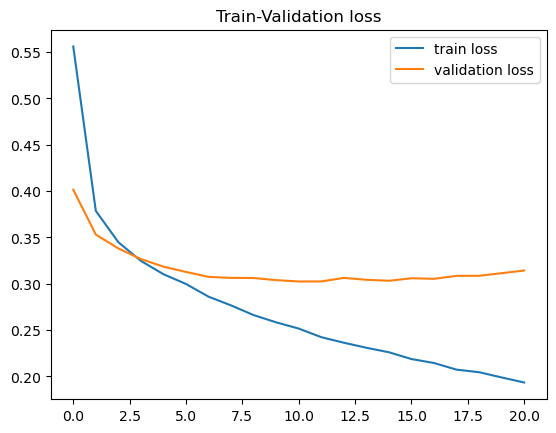

In [18]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [19]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8325, 'male': 0.875, 'average': 0.85375}
precision {'female': 0.8740157480314961, 'male': 0.8337468982630273, 'average': 0.8538813231472617}
f1 {'female': 0.852752880921895, 'male': 0.8538754764930115, 'average': 0.8533141787074533}
accuracy 0.8533163265306123


Evaluación en el conjunto el conjunto to
recall {'female': 0.6404199475065617, 'male': 0.7128953771289538, 'average': 0.6766576623177578}
precision {'female': 0.6740331491712708, 'male': 0.6813953488372093, 'average': 0.67771424900424}
f1 {'female': 0.6567967698519516, 'male': 0.6967895362663497, 'average': 0.6767931530591507}
accuracy 0.678030303030303


Evaluación en el conjunto el conjunto as
recall {'female': 0.6522911051212938, 'male': 0.7095959595959596, 'average': 0.6809435323586267}
precision {'female': 0.6778711484593838, 'male': 0.6853658536585366, 'average': 0.6816185010589602}
f1 {'female': 0.6648351648351648, 'male': 0.6972704714640199, 'average': 0.

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5912412455896052 	 Validation loss: 0.4200153704416954 	 
  1%|          | 574/57400 [01:52<2:34:55,  6.11it/s]
Epoch 2 	 Training loss: 0.3889159879514149 	 Validation loss: 0.3498104020195492 	 
  2%|▏         | 1148/57400 [03:45<2:39:23,  5.88it/s]
Epoch 3 	 Training loss: 0.34543975790514764 	 Validation loss: 0.3334288826938403 	 
  3%|▎         | 1722/57400 [05:37<2:26:29,  6.33it/s]
Epoch 4 	 Training loss: 0.325606213084289 	 Validation loss: 0.320896290368953 	 
  4%|▍         | 2296/57400 [07:29<2:28:58,  6.16it/s]
Epoch 5 	 Training loss: 0.310407604282326 	 Validation loss: 0.3136190938747535 	 
  5%|▌         | 2870/57400 [09:21<2:25:39,  6.24it/s]
Epoch 6 	 Training loss: 0.2958379211066492 	 Validation loss: 0.30874690969111557 	 
  6%|▌         | 3444/57400 [11:13<2:41:03,  5.58it/s]
Epoch 7 	 Training loss: 0.28470130145342093 	 Validation loss: 0.304292525780403 	 
  7%|▋         | 4018/57400 [13:05<2:44:32,  5.41it/s]
Epoch 8 	 Training los

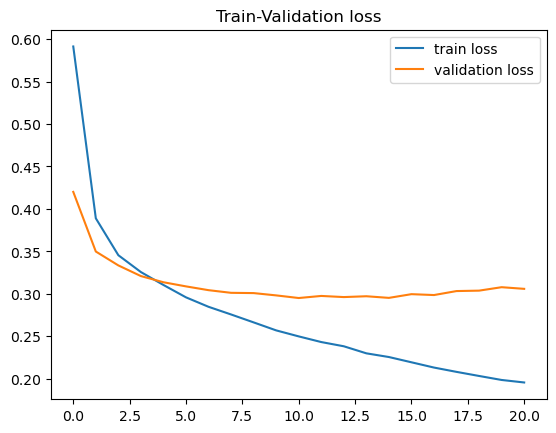

In [20]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p =train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [21]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8375, 'male': 0.8671875, 'average': 0.85234375}
precision {'female': 0.8678756476683938, 'male': 0.8366834170854272, 'average': 0.8522795323769105}
f1 {'female': 0.8524173027989823, 'male': 0.8516624040920716, 'average': 0.8520398534455269}
accuracy 0.8520408163265306


Evaluación en el conjunto el conjunto to
recall {'female': 0.6640419947506562, 'male': 0.6958637469586375, 'average': 0.6799528708546468}
precision {'female': 0.6693121693121693, 'male': 0.6908212560386473, 'average': 0.6800667126754083}
f1 {'female': 0.6666666666666666, 'male': 0.6933333333333332, 'average': 0.6799999999999999}
accuracy 0.6805555555555556


Evaluación en el conjunto el conjunto as
recall {'female': 0.6657681940700808, 'male': 0.702020202020202, 'average': 0.6838941980451414}
precision {'female': 0.6767123287671233, 'male': 0.6915422885572139, 'average': 0.6841273086621686}
f1 {'female': 0.671195652173913, 'male': 0.6967418546365916, 'ave

In [22]:
model =st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about3'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5689418627929189 	 Validation loss: 0.40408982664851817 	 
  1%|          | 574/57400 [01:53<2:38:46,  5.96it/s]
Epoch 2 	 Training loss: 0.3796161817133634 	 Validation loss: 0.346702226895397 	 
  2%|▏         | 1148/57400 [03:45<2:50:28,  5.50it/s]
Epoch 3 	 Training loss: 0.34291542080013593 	 Validation loss: 0.33069982846914714 	 
  3%|▎         | 1722/57400 [05:37<2:55:20,  5.29it/s]
Epoch 4 	 Training loss: 0.3239329806707462 	 Validation loss: 0.3206653988967508 	 
  4%|▍         | 2296/57400 [07:29<2:21:17,  6.50it/s]
Epoch 5 	 Training loss: 0.3081412615728295 	 Validation loss: 0.31300361252437203 	 
  5%|▌         | 2870/57400 [09:22<2:37:24,  5.77it/s]
Epoch 6 	 Training loss: 0.2966373525170499 	 Validation loss: 0.31058633908376854 	 
  6%|▌         | 3444/57400 [11:14<2:23:35,  6.26it/s]
Epoch 7 	 Training loss: 0.2846920777904032 	 Validation loss: 0.3042954421144421 	 
  7%|▋         | 4018/57400 [13:07<2:23:00,  6.22it/s]
Epoch 8 	 Trainin

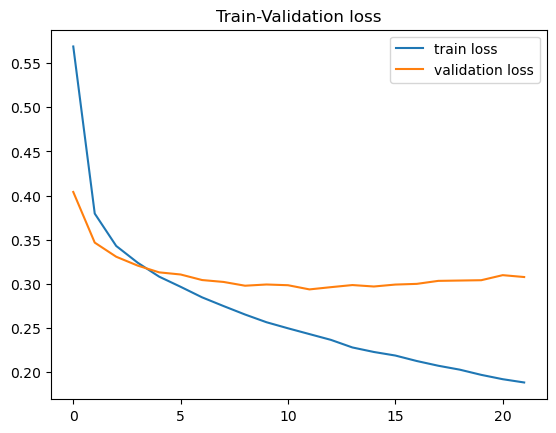

In [23]:

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [24]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.84, 'male': 0.875, 'average': 0.8574999999999999}
precision {'female': 0.875, 'male': 0.84, 'average': 0.8574999999999999}
f1 {'female': 0.8571428571428572, 'male': 0.8571428571428572, 'average': 0.8571428571428572}
accuracy 0.8571428571428571


Evaluación en el conjunto el conjunto to
recall {'female': 0.6482939632545932, 'male': 0.7128953771289538, 'average': 0.6805946701917736}
precision {'female': 0.6767123287671233, 'male': 0.6861826697892272, 'average': 0.6814474992781752}
f1 {'female': 0.6621983914209115, 'male': 0.6992840095465394, 'average': 0.6807412004837254}
accuracy 0.6818181818181818


Evaluación en el conjunto el conjunto as
recall {'female': 0.660377358490566, 'male': 0.7121212121212122, 'average': 0.686249285305889}
precision {'female': 0.6824512534818942, 'male': 0.6911764705882353, 'average': 0.6868138620350648}
f1 {'female': 0.6712328767123288, 'male': 0.7014925373134329, 'average': 0.6863627070128808

Resultados finales

In [25]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.8541656297652791
f1 etiqueta male: 0.8542269125759802
f1 etiqueta female:  0.8541043469545782


TO
Resultado global f1: 0.6791781178476254
f1 etiqueta male: 0.6964689597154075
f1 etiqueta female:  0.6618872759798432


AS
Resultado global f1: 0.6837947595225752
f1 etiqueta male: 0.6985016211380147
f1 etiqueta female:  0.6690878979071355


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.85453125
recall etiqueta male: 0.8723958333333334
recall etiqueta female:  0.8366666666666667


TO
Resultado global recall: 0.6790684011213928
recall etiqueta male: 0.7072181670721817
recall etiqueta female:  0.6509186351706037


AS
Resultado global recall: 0.683695671903219
recall etiqueta male: 0.7079124579124579
recall etiqueta female:  0.6594788858939802


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.8545536185080573
precision etiqueta male: 0.8368101051161515
precision etiqueta female:  0.8722971318

# TO

In [24]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [25]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6955565667941596 	 Validation loss: 0.6941897747880321 	 
  1%|          | 574/57400 [01:41<2:38:01,  5.99it/s]
Epoch 2 	 Training loss: 0.6948413680654785 	 Validation loss: 0.6934898475469169 	 
  2%|▏         | 1148/57400 [03:22<2:35:48,  6.02it/s]
Epoch 3 	 Training loss: 0.6942368352247033 	 Validation loss: 0.693118612645036 	 
  3%|▎         | 1722/57400 [05:03<2:34:58,  5.99it/s]
Epoch 4 	 Training loss: 0.6937940076045458 	 Validation loss: 0.693043986619529 	 
  4%|▍         | 2296/57400 [06:45<2:32:17,  6.03it/s]
Epoch 5 	 Training loss: 0.6935281978874672 	 Validation loss: 0.693943043886605 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:26<2:18:24,  6.57it/s]
Epoch 6 	 Training loss: 0.6933306332041578 	 Validation loss: 0.693772041191489 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:07<2:42:19,  5.54it/s]
Epoch 7 	 Training loss: 0.6933866763156465 	 Validation loss: 0.6929697091296568 	 
  7%|▋         | 4018/

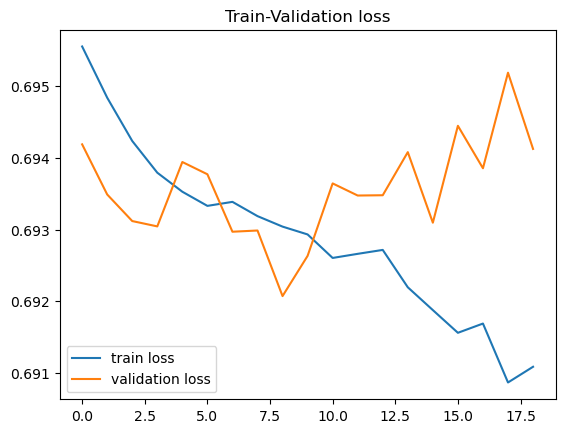

In [26]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [26]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.425, 'male': 0.6979166666666666, 'average': 0.5614583333333333}
precision {'female': 0.5944055944055944, 'male': 0.5381526104417671, 'average': 0.5662791024236807}
f1 {'female': 0.49562682215743437, 'male': 0.6077097505668935, 'average': 0.5516682863621639}
accuracy 0.5586734693877551


Evaluación en el conjunto el conjunto to
recall {'female': 0.30183727034120733, 'male': 0.7469586374695864, 'average': 0.5243979539053969}
precision {'female': 0.5251141552511416, 'male': 0.5357766143106457, 'average': 0.5304453847808936}
f1 {'female': 0.38333333333333336, 'male': 0.6239837398373984, 'average': 0.5036585365853659}
accuracy 0.5328282828282829


Evaluación en el conjunto el conjunto as
recall {'female': 0.38544474393531, 'male': 0.702020202020202, 'average': 0.543732472977756}
precision {'female': 0.5478927203065134, 'male': 0.549407114624506, 'average': 0.5486499174655097}
f1 {'female': 0.4525316455696203, 'male': 0.616407

In [27]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to2'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6962243582313484 	 Validation loss: 0.6949446635731196 	 
  1%|          | 574/57400 [01:42<2:43:19,  5.80it/s]
Epoch 2 	 Training loss: 0.6948755071968983 	 Validation loss: 0.6956400446972605 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:24<2:45:18,  5.67it/s]
Epoch 3 	 Training loss: 0.6942670990158041 	 Validation loss: 0.6954019988997507 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:06<2:33:04,  6.06it/s]
Epoch 4 	 Training loss: 0.6938925460240567 	 Validation loss: 0.6938100184424448 	 
  4%|▍         | 2296/57400 [06:48<2:46:26,  5.52it/s]
Epoch 5 	 Training loss: 0.6939112343646924 	 Validation loss: 0.6929257188813162 	 
  5%|▌         | 2870/57400 [08:30<2:35:07,  5.86it/s]
Epoch 6 	 Training loss: 0.693724731535031 	 Validation loss: 0.6940759905314041 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:11<2:25:40,  6.17it/s]
Epoch 7 	 Training loss: 0.6934976475994762 	 Validation loss: 0.6927772285

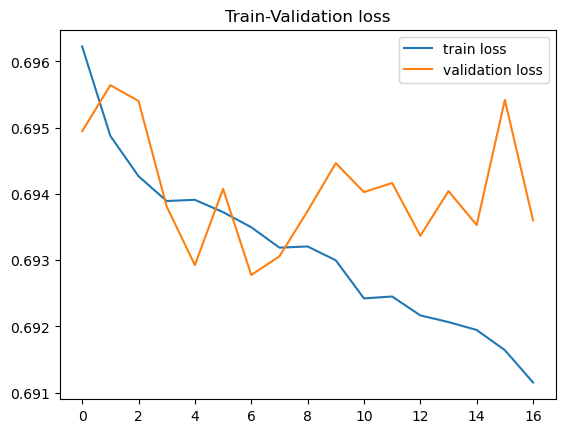

In [29]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [28]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.535, 'male': 0.4895833333333333, 'average': 0.5122916666666667}
precision {'female': 0.5219512195121951, 'male': 0.5026737967914439, 'average': 0.5123125081518195}
f1 {'female': 0.528395061728395, 'male': 0.49604221635883905, 'average': 0.512218639043617}
accuracy 0.5127551020408163


Evaluación en el conjunto el conjunto to
recall {'female': 0.4881889763779528, 'male': 0.5985401459854015, 'average': 0.5433645611816771}
precision {'female': 0.5299145299145299, 'male': 0.5578231292517006, 'average': 0.5438688295831153}
f1 {'female': 0.5081967213114754, 'male': 0.5774647887323943, 'average': 0.5428307550219349}
accuracy 0.5454545454545454


Evaluación en el conjunto el conjunto as
recall {'female': 0.5363881401617251, 'male': 0.48484848484848486, 'average': 0.5106183125051049}
precision {'female': 0.49379652605459057, 'male': 0.5274725274725275, 'average': 0.510634526763559}
f1 {'female': 0.5142118863049095, 'male': 0.5052

In [29]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to3'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6963866935582111 	 Validation loss: 0.6946944392333596 	 
  1%|          | 574/57400 [01:44<2:38:38,  5.97it/s]
Epoch 2 	 Training loss: 0.6950075756174346 	 Validation loss: 0.6930404396380409 	 
  2%|▏         | 1148/57400 [03:29<2:37:08,  5.97it/s]
Epoch 3 	 Training loss: 0.6941198952729694 	 Validation loss: 0.6932277234934144 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:12<2:32:36,  6.08it/s]
Epoch 4 	 Training loss: 0.6937318354948888 	 Validation loss: 0.6941572013547865 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [06:56<2:33:16,  5.99it/s]
Epoch 5 	 Training loss: 0.6933459412137806 	 Validation loss: 0.6929535219224833 	 
  5%|▌         | 2870/57400 [08:40<2:32:53,  5.94it/s]
Epoch 6 	 Training loss: 0.6932829786676148 	 Validation loss: 0.6933356968023009 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:24<2:21:03,  6.38it/s]
Epoch 7 	 Training loss: 0.6932770986797918 	 Validation loss: 0.693538982

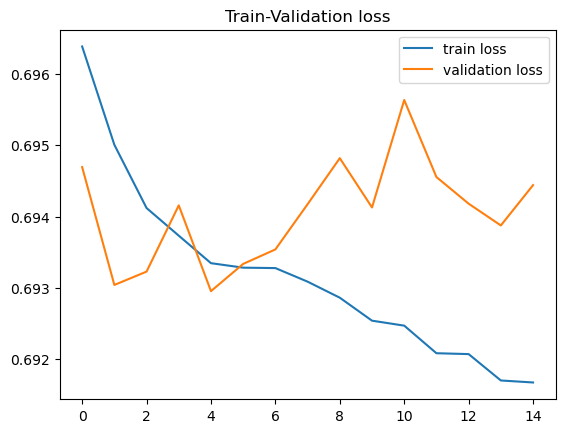

In [32]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [30]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.69, 'male': 0.3333333333333333, 'average': 0.5116666666666666}
precision {'female': 0.518796992481203, 'male': 0.5079365079365079, 'average': 0.5133667502088555}
f1 {'female': 0.592274678111588, 'male': 0.4025157232704403, 'average': 0.4973952006910141}
accuracy 0.5153061224489796


Evaluación en el conjunto el conjunto to
recall {'female': 0.7322834645669292, 'male': 0.34549878345498786, 'average': 0.5388911240109585}
precision {'female': 0.5091240875912408, 'male': 0.5819672131147541, 'average': 0.5455456503529974}
f1 {'female': 0.6006458557588805, 'male': 0.43358778625954203, 'average': 0.5171168210092113}
accuracy 0.5315656565656566


Evaluación en el conjunto el conjunto as
recall {'female': 0.6522911051212938, 'male': 0.3181818181818182, 'average': 0.485236461651556}
precision {'female': 0.47265625, 'male': 0.49411764705882355, 'average': 0.4833869485294118}
f1 {'female': 0.5481313703284258, 'male': 0.3870967741935

Resultados finales

In [31]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.5204273753655984
f1 etiqueta male: 0.502089230065391
f1 etiqueta female:  0.5387655206658057


TO
Resultado global f1: 0.5212020375388373
f1 etiqueta male: 0.5450121049431116
f1 etiqueta female:  0.4973919701345631


AS
Resultado global f1: 0.5039404694254803
f1 etiqueta male: 0.5029226381166421
f1 etiqueta female:  0.5049583007343186


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5284722222222222
recall etiqueta male: 0.5069444444444444
recall etiqueta female:  0.55


TO
Resultado global recall: 0.5355512130326775
recall etiqueta male: 0.5636658556366586
recall etiqueta female:  0.5074365704286964


AS
Resultado global recall: 0.5131957490448056
recall etiqueta male: 0.5016835016835017
recall etiqueta female:  0.5247079964061097


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5306527869281186
precision etiqueta male: 0.516254305056573
precision etiqueta female:  0.5450512687996641


# AS

In [32]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [33]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as1'


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6983324897829248 	 Validation loss: 0.6957626676155348 	 
  1%|          | 574/57400 [01:42<2:40:42,  5.89it/s]
Epoch 2 	 Training loss: 0.6944740416696262 	 Validation loss: 0.693534044896142 	 
  2%|▏         | 1148/57400 [03:24<2:31:02,  6.21it/s]
Epoch 3 	 Training loss: 0.693894950043449 	 Validation loss: 0.6917910666789039 	 
  3%|▎         | 1722/57400 [05:05<2:27:40,  6.28it/s]
Epoch 4 	 Training loss: 0.6925179456792226 	 Validation loss: 0.6924731084855936 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:46<2:30:45,  6.09it/s]
Epoch 5 	 Training loss: 0.6912922444866925 	 Validation loss: 0.6929007334224249 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:26<2:31:40,  5.99it/s]
Epoch 6 	 Training loss: 0.6900760257285646 	 Validation loss: 0.6938059663368483 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [10:08<2:25:47,  6.17it/s]
Epoch 7 	 Training loss: 0.6894618784716736 	 Validation loss: 0.69165394669

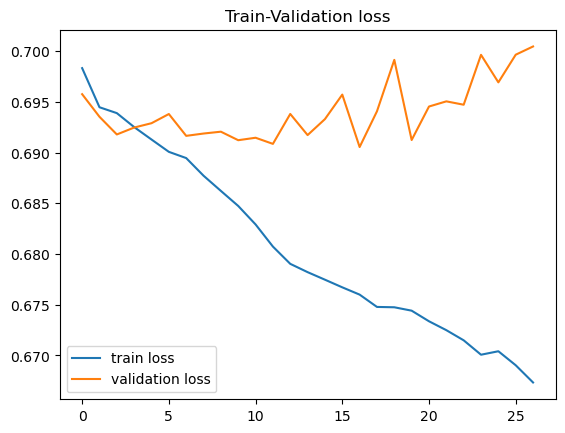

In [37]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [34]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.6525, 'male': 0.7057291666666666, 'average': 0.6791145833333333}
precision {'female': 0.6978609625668449, 'male': 0.6609756097560976, 'average': 0.6794182861614713}
f1 {'female': 0.6744186046511628, 'male': 0.6826196473551638, 'average': 0.6785191260031633}
accuracy 0.6785714285714286


Evaluación en el conjunto el conjunto to
recall {'female': 0.7086614173228346, 'male': 0.754257907542579, 'average': 0.7314596624327068}
precision {'female': 0.7277628032345014, 'male': 0.7363420427553444, 'average': 0.7320524229949229}
f1 {'female': 0.7180851063829787, 'male': 0.7451923076923077, 'average': 0.7316387070376432}
accuracy 0.7323232323232324


Evaluación en el conjunto el conjunto as
recall {'female': 0.8086253369272237, 'male': 0.73989898989899, 'average': 0.7742621634131068}
precision {'female': 0.7444168734491315, 'male': 0.804945054945055, 'average': 0.7746809641970933}
f1 {'female': 0.7751937984496123, 'male': 0.7710526

In [35]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as2'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6981082442330151 	 Validation loss: 0.6931363707881862 	 
  1%|          | 574/57400 [01:42<2:35:19,  6.10it/s]
Epoch 2 	 Training loss: 0.6951158879525986 	 Validation loss: 0.6913578873973781 	 
  2%|▏         | 1148/57400 [03:24<2:33:34,  6.10it/s]
Epoch 3 	 Training loss: 0.693062990488491 	 Validation loss: 0.6919086555303153 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:05<2:34:01,  6.03it/s]
Epoch 4 	 Training loss: 0.6918974807453487 	 Validation loss: 0.6918761932243735 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [06:47<2:41:26,  5.69it/s]
Epoch 5 	 Training loss: 0.6906546908803933 	 Validation loss: 0.6905051742569875 	 
  5%|▌         | 2870/57400 [08:29<2:49:07,  5.37it/s]
Epoch 6 	 Training loss: 0.6900941557169792 	 Validation loss: 0.6915892443414462 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:10<2:39:49,  5.63it/s]
Epoch 7 	 Training loss: 0.6877257267357165 	 Validation loss: 0.6926387841

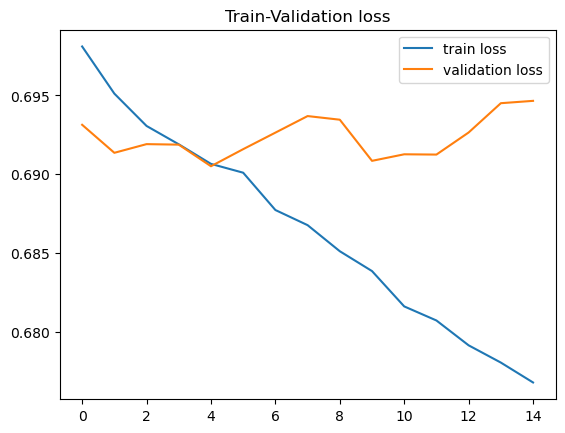

In [40]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [36]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8175, 'male': 0.3515625, 'average': 0.58453125}
precision {'female': 0.5677083333333334, 'male': 0.6490384615384616, 'average': 0.6083733974358975}
f1 {'female': 0.6700819672131147, 'male': 0.45608108108108103, 'average': 0.5630815241470979}
accuracy 0.5892857142857143


Evaluación en el conjunto el conjunto to
recall {'female': 0.8267716535433071, 'male': 0.3381995133819951, 'average': 0.5824855834626511}
precision {'female': 0.5366269165247018, 'male': 0.6780487804878049, 'average': 0.6073378485062534}
f1 {'female': 0.6508264462809917, 'male': 0.45129870129870125, 'average': 0.5510625737898465}
accuracy 0.5732323232323232


Evaluación en el conjunto el conjunto as
recall {'female': 0.8382749326145552, 'male': 0.3333333333333333, 'average': 0.5858041329739443}
precision {'female': 0.5408695652173913, 'male': 0.6875, 'average': 0.6141847826086957}
f1 {'female': 0.6575052854122622, 'male': 0.4489795918367347, 'average': 0

In [37]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as3'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.7075757067585656 	 Validation loss: 0.694625492823326 	 
  1%|          | 574/57400 [01:41<2:42:26,  5.83it/s]
Epoch 2 	 Training loss: 0.7079160009942403 	 Validation loss: 0.6970021259986748 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:22<2:35:44,  6.02it/s]
Epoch 3 	 Training loss: 0.7082765625744332 	 Validation loss: 0.6970908560995328 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:04<2:42:17,  5.72it/s]
Epoch 4 	 Training loss: 0.7089017051229909 	 Validation loss: 0.6946457311258478 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [06:46<2:43:31,  5.62it/s]
Epoch 5 	 Training loss: 0.7079016490472734 	 Validation loss: 0.6992038276235936 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [08:28<2:26:55,  6.19it/s]
Epoch 6 	 Training loss: 0.7078586120015653 	 Validation loss: 0.6985197188490528 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [10:10<2:22:20,  6.32it/s]
Epoch 7 	 Trainin

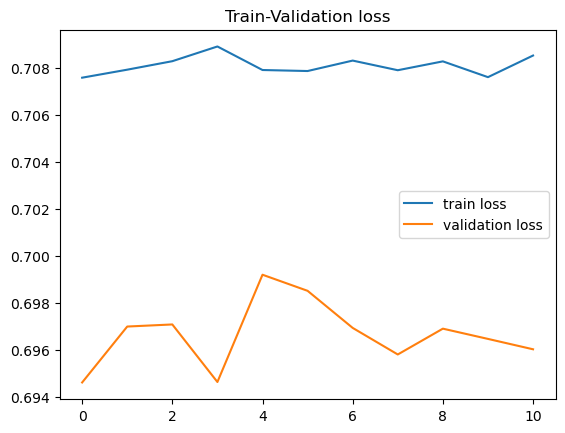

In [43]:
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [38]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about


c:\Users\FarinhOso\anaconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall {'female': 1.0, 'male': 0.0, 'average': 0.5}
precision {'female': 0.5102040816326531, 'male': 0.0, 'average': 0.25510204081632654}
f1 {'female': 0.6756756756756758, 'male': 0.0, 'average': 0.3378378378378379}
accuracy 0.5102040816326531


Evaluación en el conjunto el conjunto to
recall {'female': 1.0, 'male': 0.0024330900243309003, 'average': 0.5012165450121655}
precision {'female': 0.48166877370417194, 'male': 1.0, 'average': 0.7408343868520859}
f1 {'female': 0.6501706484641638, 'male': 0.0048543689320388345, 'average': 0.32751250869810133}
accuracy 0.4823232323232323


Evaluación en el conjunto el conjunto as
recall {'female': 1.0, 'male': 0.0, 'average': 0.5}
precision {'female': 0.48370273794002605, 'male': 0.0, 'average': 0.24185136897001303}
f1 {'female': 0.6520210896309314, 'male': 0.0, 'average': 0.3260105448154657}
accuracy 0.48370273794002605


c:\Users\FarinhOso\anaconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Resultados finales

In [39]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.526479495996033
f1 etiqueta male: 0.37956690947874827
f1 etiqueta female:  0.6733920825133177


TO
Resultado global f1: 0.5367379298418636
f1 etiqueta male: 0.4004484593076826
f1 etiqueta female:  0.6730274003760448


AS
Resultado global f1: 0.5507920661514147
f1 etiqueta male: 0.4066774078052274
f1 etiqueta female:  0.6949067244976019


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5878819444444444
recall etiqueta male: 0.3524305555555555
recall etiqueta female:  0.8233333333333334


TO
Resultado global recall: 0.6050539303025078
recall etiqueta male: 0.36496350364963503
recall etiqueta female:  0.8451443569553806


AS
Resultado global recall: 0.6200220987956837
recall etiqueta male: 0.35774410774410775
recall etiqueta female:  0.8823000898472596


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5142979081378984
precision etiqueta male: 0.4366713570981864
precision etiqueta female:  0